In [37]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [38]:
count = 0 
dirs = os.listdir('Images/')
for dir in dirs:
    files = list(os.listdir('Images/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' Images')
    count = count + len(files)
print( 'Images Folder has '+ str(count) + ' Images')

Abnormal heartbeat Patients Folder has 699 Images
Myocardial Infarction Patients Folder has 956 Images
Normal Person Patients Folder has 852 Images
Patient that have History of MI Folder has 516 Images
Images Folder has 3023 Images


In [39]:
base_dir = 'Images/'
img_size = 180
batch = 32

In [40]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 3023 files belonging to 4 classes.
Using 2419 files for training.
Found 3023 files belonging to 4 classes.
Using 604 files for validation.


In [41]:
ECG_names = train_ds.class_names
ECG_names

['Abnormal heartbeat Patients',
 'Myocardial Infarction Patients',
 'Normal Person Patients',
 'Patient that have History of MI']

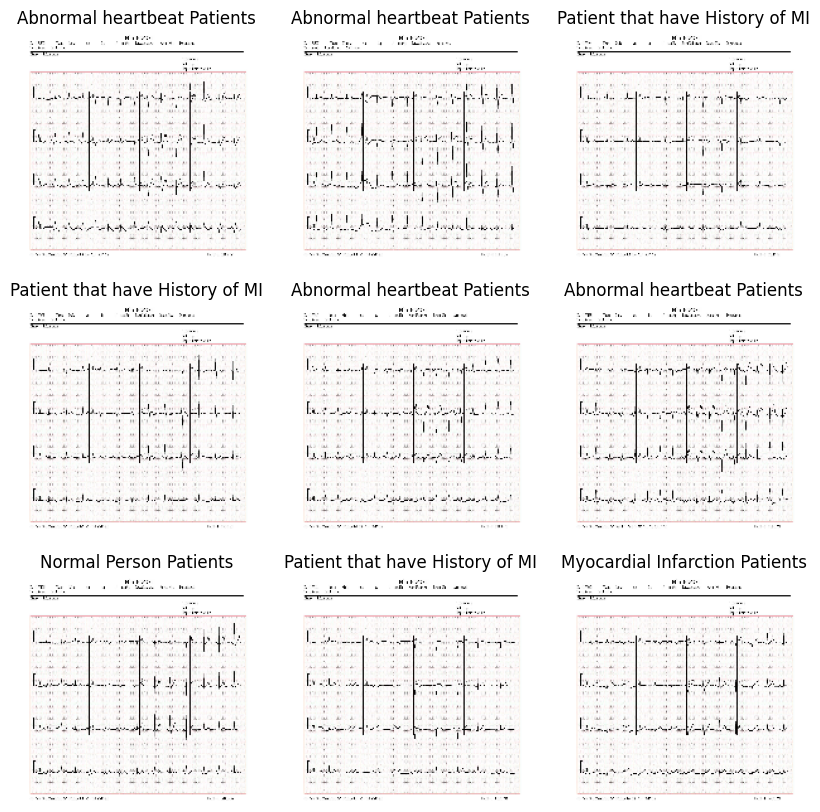

In [42]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(ECG_names[labels[i]])
        plt.axis('off')

In [43]:
AUTOTUNE = tf.data.AUTOTUNE

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [45]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [46]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(factor=0.2)
], name="data_augmentation")

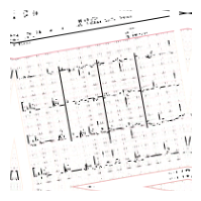

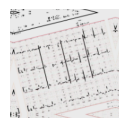

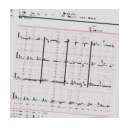

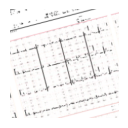

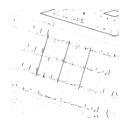

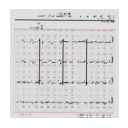

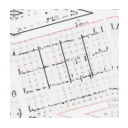

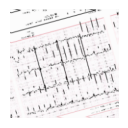

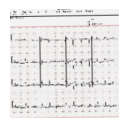

In [47]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.show()

In [48]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 180, 180, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 90, 90, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 90, 90, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 45, 45, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 45, 45, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 30976)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 128)                   │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 5)                     │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 312ms/step - accuracy: 0.2885 - loss: 1.4650 - val_accuracy: 0.3129 - val_loss: 1.3721
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - accuracy: 0.3072 - loss: 1.3747 - val_accuracy: 0.3129 - val_loss: 1.3942
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 303ms/step - accuracy: 0.3208 - loss: 1.3659 - val_accuracy: 0.2682 - val_loss: 1.4138
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - accuracy: 0.3117 - loss: 1.3674 - val_accuracy: 0.3129 - val_loss: 1.3659
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.3299 - loss: 1.3561 - val_accuracy: 0.2450 - val_loss: 1.4463
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.3902 - loss: 1.2887 - val_accuracy: 0.3990 - val_loss: 1.4523
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.4473 - loss: 1.2187 - val_accuracy: 0.4553 - val_loss: 1.1415
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.4986 - loss: 1.1233 - val_accu

In [52]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The ECG Image belongs to ' + ECG_names [np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [53]:
classify_images('Sample/HB(27).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


'The ECG Image belongs to Abnormal heartbeat Patients with a score of 98.849884'

In [54]:
model.save('ECG_Recog_Model.keras')